In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_log_error,mean_squared_error, mean_absolute_error, r2_score

import optuna
import lightgbm as lgb
warnings.filterwarnings('ignore', category=FutureWarning, module='optuna')
warnings.filterwarnings('ignore', category=FutureWarning, module='lightgbm')

import torch
from sklearn.pipeline import Pipeline
warnings.simplefilter(action='ignore', category=FutureWarning)

In [77]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [78]:
target = 'Premium Amount'

In [79]:
train_df = train_df.drop(columns=['Unnamed: 0'], errors='ignore')

In [80]:
def date(df):

  df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
  df['Year'] = df['Policy Start Date'].dt.year
  df['Day'] = df['Policy Start Date'].dt.day
  df['Month'] = df['Policy Start Date'].dt.month
  df['Month_name'] = df['Policy Start Date'].dt.month_name()
  df['Day_of_week'] = df['Policy Start Date'].dt.day_name()
  df['Week'] = df['Policy Start Date'].dt.isocalendar().week
  df['Year_sin'] = np.sin(2 * np.pi * df['Year'])
  df['Year_cos'] = np.cos(2 * np.pi * df['Year'])
  min_year = df['Year'].min()
  max_year = df['Year'].max()
  df['Year_sin'] = np.sin(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
  df['Year_cos'] = np.cos(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
  df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12) 
  df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
  df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)  
  df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
  df['Group']=(df['Year'] - 2020) * 48 + df['Month'] * 4 + df['Day'] // 7
  
  df.drop('Policy Start Date', axis=1, inplace=True)

  return df

train_df = date(train_df)
test_df = date(test_df)

In [81]:
numerical_columns = train_df.select_dtypes(exclude=['object']).columns
categorical_columns = train_df.select_dtypes(include=['object']).columns

In [82]:
X = train_df.drop(columns=[target, 'Year', 'Month', 'Week', 'Day', 'id'])
y = train_df[target]

In [83]:
numerical_columns = numerical_columns.drop([target, 'Year', 'Month', 'Week', 'Day', 'id'])

In [84]:
train_df = train_df.drop(columns=[target, 'Year', 'Month', 'Week', 'Day', 'id'])
test_df = test_df.drop(columns=['Year', 'Month', 'Week', 'Day', 'id'])

In [85]:
test_df.columns

Index(['Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Customer Feedback',
       'Smoking Status', 'Exercise Frequency', 'Property Type', 'Month_name',
       'Day_of_week', 'Year_sin', 'Year_cos', 'Month_sin', 'Month_cos',
       'Day_sin', 'Day_cos', 'Group'],
      dtype='object')

In [86]:
# Preprocessing pipeline for numerical features
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('scaler', StandardScaler())                       # Scale numerical features
])

# Preprocessing pipeline for categorical features
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))                      # Encode categorical features
])

# Combine pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_columns),
        ('cat', cat_pipeline, categorical_columns)
    ]
)

# Preprocess train and test data
X_processed = preprocessor.fit_transform(X)
test_processed = preprocessor.transform(test_df)

In [87]:
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [88]:
# Define Optuna optimization function
def objective(trial):
    # Define parameter search space
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'dart',
        'num_leaves': trial.suggest_int('num_leaves', 200, 512),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-2, 1e-1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 5, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 6, 16),  # -1 means no limit
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-4, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-4, 10.0),
        'seed' : 42,
        'verbose': -1

    }

    # Create a LightGBM dataset
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    # Train LightGBM model
    model = lgb.train(
        param,
        dtrain,
        valid_sets=[dval],
    )

    # Predict on validation set
    y_val_pred = model.predict(X_val)
    
    # Compute RMSLE using sklearn's root_mean_squared_log_error
    rmsle = root_mean_squared_log_error(y_val, np.maximum(y_val_pred, 0))
    return rmsle

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [89]:
# # Initialize or update the best_params dictionary
best_params = {
    'boosting_type': 'dart',
    'num_leaves': 390,
    'learning_rate': 0.0246801204651501232,
    'feature_fraction': 0.9883068358315126,
    'bagging_fraction': 0.7201712704805496,
    'bagging_freq': 7,
    'min_data_in_leaf': 50,
    'max_depth': 15,
    'lambda_l1': 0.0011290211269753322,
    'lambda_l2': 3.056310541294088,
    'seed': 42
}

In [90]:
final_model = lgb.train(
    best_params,
    lgb.Dataset(X_processed, label=y),
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1284
[LightGBM] [Info] Number of data points in the train set: 1200000, number of used features: 67
[LightGBM] [Info] Start training from score 1102.544822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



Performance Metrics:
------------------------------
RMSLE: 1.0640
RMSE: 907.4470
MAE: 625.7502
R²: -0.1006
MAPE: 204.88%


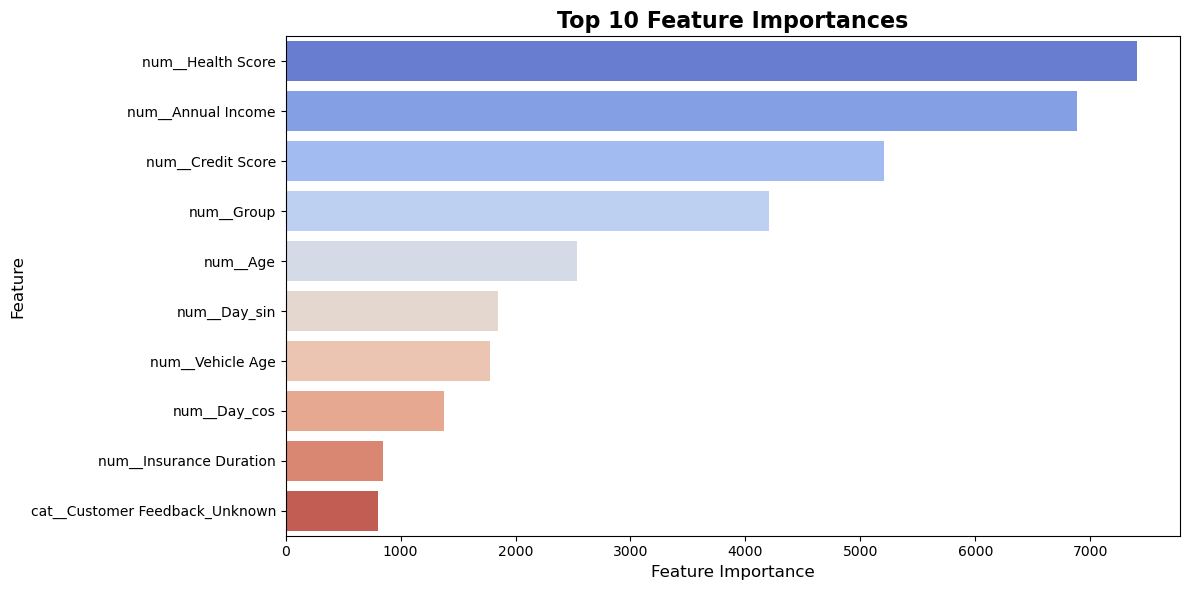

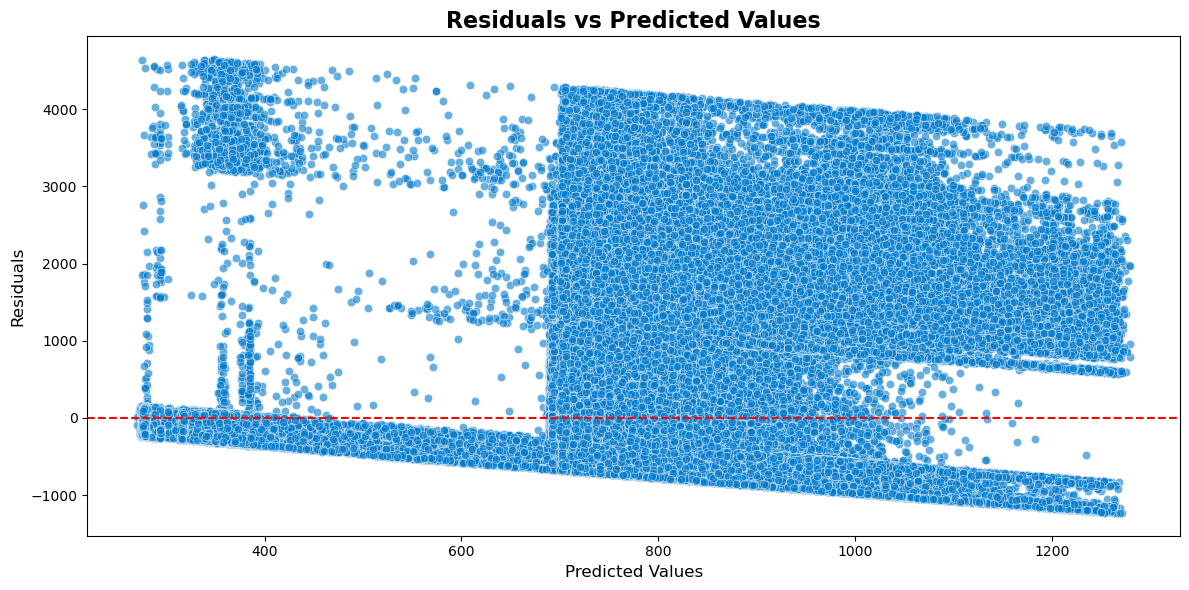

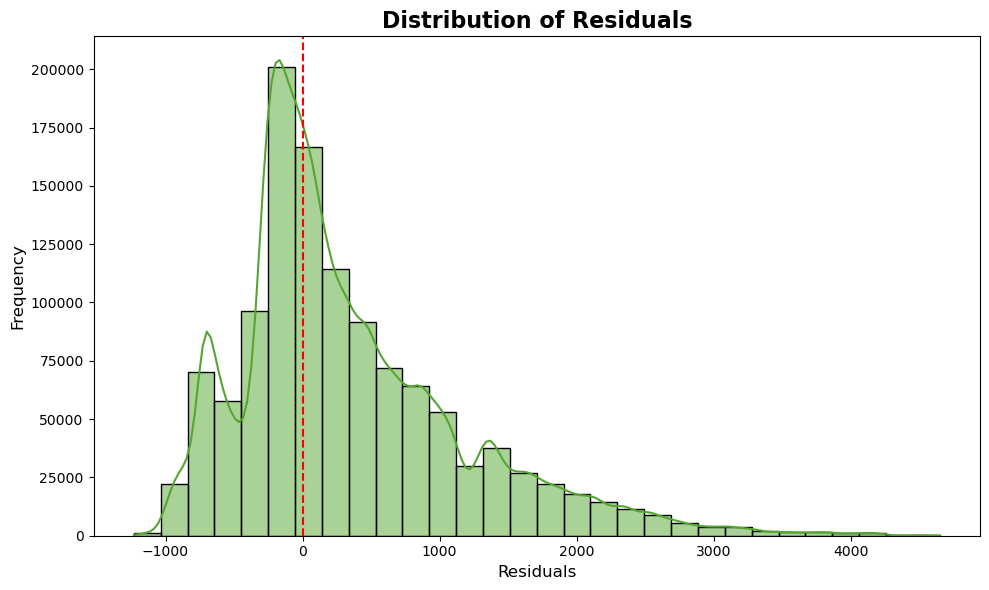

In [91]:
# 1. Performance Metrics
y_pred = final_model.predict(X_processed)

# Calcul des métriques
rmsle = root_mean_squared_log_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
mape = np.mean(np.abs((y - y_pred) / y)) * 100

# Display performance metrics
print(f'\nPerformance Metrics:\n{'-'*30}')
print(f'RMSLE: {rmsle:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')
print(f'MAPE: {mape:.2f}%')

# 2. Feature Importance
importances = final_model.feature_importance(importance_type='split')  # or 'gain'
features = preprocessor.get_feature_names_out()
sorted_indices = importances.argsort()[::-1]

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': [features[i] for i in sorted_indices],
    'Importance': importances[sorted_indices]
})

# Plot top 10 feature importances
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='coolwarm')
plt.title('Top 10 Feature Importances', fontsize=16, fontweight='bold')
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# 3. Residual Analysis
residuals = y - y_pred

# Residuals vs Predicted Values
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, color='#007acc')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title('Residuals vs Predicted Values', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.tight_layout()
plt.show()

# Residual Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color='#55a630')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
plt.title('Distribution of Residuals', fontsize=16, fontweight='bold')
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

In [17]:
id_df = pd.read_csv('./data/test.csv')['id']

In [18]:
test_predictions = final_model.predict(test_processed, num_iteration=final_model.best_iteration)

# Prepare submission file
submission = pd.DataFrame({'id': test_df['id'], 'Premium Amount': test_predictions})
submission.to_csv("submission.csv", index=False)

KeyError: 'id'